# 1 &emsp; The Supply Chain Graph 

These set of tutorials follow the same tutorial made by [tngTUDOR](https://github.com/brightway-lca/from-the-ground-up). Teaching material for Brightway2.5, starting from the foundations. A different approach from the existing teaching material which describes how Bightway works, with a focus on why Brightway does what it does. These notebooks are designed to be used in class, so do not contain a ton of instruction.

In [1]:
import bw2data as bd

About bw2data: The first thing to learn about `bw2data` is the concept of projects. Each project is self-contained, and independent of other projects. Each has its own subdirectory. This can lead to data duplication, but helps keep each project safe from the changes in the others.

We start in the `default` project:

In [2]:
bd.projects.current

'default'

With directory:

In [3]:
bd.projects.dir

PosixPath('/Users/mmendez/Library/Application Support/Brightway3/default.c21f969b5f03d33d43e04f8f136e7682')

Make it easy to reset this project:

In [4]:
try:
    bd.projects.delete_project("1 Supply Chain Graph", True)
except ValueError:
    pass

Let's create a new project:

In [5]:
bd.projects.set_current('1 Supply Chain Graph')
bd.projects.current

'1 Supply Chain Graph'

A graph can have nodes of any type, but for the purposes of LCA it is convenient to separate activity nodes, product nodes, elementary flow nodes, and characterization nodes. We will also use a shortcut (for now) and assume that each activity produces exactly one product, so we can collapse activity and products nodes into a single node.

Let's think about a simple product system - a bike. Here is a graph:

<img src='images/simple-graph.png' width='400'>

To enter this data into BW, we need to create the nodes, and then the edges. We will create these nodes in a `Database`. A database in BW is just a collection of nodes - it can be large or small, there aren't any general rules.

In [6]:
db = bd.Database('bike')
db.register() # Let the metadata system know this database exists. Not necessary if using a `bw2io` importer.

Our first node. We specify some additional data to make it easier to find or use this node later on.

In [7]:
data = {
    'code': 'bike',
    'name': 'bike production',
    'location': 'DK',
    'unit': 'bike',
}

bike = db.new_node(**data)  # Here I needed to upgrade bw2data using conda upgrade bw2data
bike.save()

In [8]:
data = {
    'code': 'ng',
    'name': 'natural gas production',
    'location': 'NO',
    'unit': 'MJ'
}

ng = db.new_node(**data)
ng.save()

In [9]:
data = {
    'code': 'cf',
    'name': 'carbon fibre production',
    'location': 'DE',
    'unit': 'kg'
}

cf = db.new_node(**data)
cf.save()

We can also define nodes like this. Note that this node has a `type`.

In [10]:
co2 = db.new_node(
    code='co2', 
    name="Carbon Dioxide", 
    categories=('air',),
    type='emission',
    unit='kg'
)

co2.save()

We also need to create edges between the nodes. We can do this in many ways here is one:

In [11]:
bike.new_edge(
    amount=2.5, 
    type='technosphere',
    input=cf
).save()

What about some uncertainty? We use [stats_arrays](https://stats-arrays.readthedocs.io/en/latest/) to model probability distribution functions.

In [12]:
cf.new_edge(
    amount=237.3,  # plus 58 kWh of electricity, in ecoinvent 3.8 
    uncertainty_type=5, 
    minimum=200, 
    maximum=300, 
    type='technosphere',
    input=ng,
).save()

In [13]:
cf.new_edge(
    amount=26.6, 
    uncertainty_type=5, 
    minimum=26,
    maximum=27.2, 
    type='biosphere',
    input=co2,
).save()

Brightway will assume that the a `production` exchange of amount 1 in each node unless you tell it otherwise.

To define characterization nodes and edges, we use a difference data structure:


In [14]:
ipcc = bd.Method(('IPCC',))
ipcc.write([
    (co2.key, {'amount': 1, 'uncertainty_type': 3, 'loc': 1, 'scale': 0.05}),
])

This is already enough to do an LCA. Let's check what our answer should be. Without uncertainty, to make one bike we need 2.5 kg of carbon fibre, and carbon fibre produces 26.6 kg CO<sub>2</sub> per kg of carbon fibre, so we are looking for around 60 kg CO<sub>2</sub>-eq, or more precisely we need 26.6x2.5= 66.5 kg CO<sub>2</sub>-eq.

Let's load the calculation module `bw2calc` to run the LCA!lca = bc.LCA(demand={bike: 1}, method=('IPCC',))
lca.lci()
lca.lcia()
lca.score

In [15]:
import bw2calc as bc

In [16]:
lca = bc.LCA(demand={bike: 1}, method=('IPCC',))
lca.lci()
lca.lcia()
lca.score

66.50000095367433

Nice! Exactly as expected :)

In [18]:
lca = bc.LCA(demand={bike: 1}, method=('IPCC',), use_distributions=True)
lca.lci()
lca.lcia()

for _ in range(10):
    next(lca)
    print(lca.score)

65.3753741036326
67.3391917553362
64.06236464961928
68.3204482393596
68.05989063729588
68.37486525408302
60.933960479066506
71.90003562725882
64.96023768783259
62.96931076983532


To use uncertainty, we tell the `import pandas as pd
` object to use the probability distributions:

In [19]:
import pandas as pd

In [20]:
df_2 = pd.DataFrame([
    {
        'score': lca.score, 
        'inv': lca.inventory.sum(), 
        'char': lca.characterization_matrix.sum()
    } for _, _ in zip(lca, range(100))
])

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

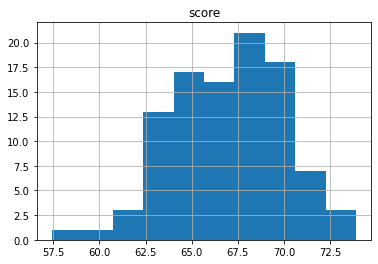

In [21]:
df_2.hist('score')

In addition to storing and using nodes and edges, our graph database can be searched in different ways. Let's show this with a larger database, more specifically with the [US Environmentally-Extended Input-Output (USEEIO)](https://www.epa.gov/land-research/us-environmentally-extended-input-output-useeio-technical-content).

We can use a shortcut to install some data:

In [22]:
import bw2io as bi
bi.useeio11()

Unzipping file
Importing data
Applying strategy: json_ld_allocate_datasets
Applying strategy: json_ld_get_normalized_exchange_locations
Applying strategy: json_ld_convert_unit_to_reference_unit
Applying strategy: json_ld_get_activities_list_from_rawdata
Applying strategy: json_ld_add_products_as_activities
Applying strategy: json_ld_get_normalized_exchange_units
Applying strategy: json_ld_add_activity_unit
Applying strategy: json_ld_rename_metadata_fields
Applying strategy: json_ld_location_name
Applying strategy: json_ld_remove_fields
Applying strategy: json_ld_fix_process_type
Applying strategy: json_ld_label_exchange_type
Applying strategy: json_ld_prepare_exchange_fields_for_linking
Applying strategy: add_database_name
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: normalize_units
Applied 17 strategies in 0.82 seconds
Moved 1873 biosphere flows to `self.data`
2649 datasets
162926 exchanges
0 unlinked exchanges
  
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Title: Writing activities to SQLite3 database:
  Started: 08/09/2022 15:59:09
  Finished: 08/09/2022 15:59:16
  Total time elapsed: 00:00:06
  CPU %: 2.10
  Memory %: 2.05
Created database: US EEIO 1.1
Applying strategy: json_ld_lcia_add_method_metadata
Applying strategy: json_ld_lcia_convert_to_list
Applying strategy: json_ld_lcia_set_method_metadata
Applying strategy: json_ld_lcia_reformat_cfs_as_exchanges
Applying strategy: normalize_units
Applied 5 strategies in 0.01 seconds
19 methods
4511 cfs
0 unlinked cfs
Wrote 19 LCIA methods with 4511 characterization factors


In [23]:
bd.databases

Databases dictionary with 2 object(s):
	US EEIO 1.1
	bike

Now we can see out bike together with a larger database.

In [24]:
db = bd.Database("US EEIO 1.1")
db.name

'US EEIO 1.1'

This database has processes **and** products. What would this mean for drawing a graph?

In [25]:
{node['type'] for node in db}

{'emission', 'process', 'product'}

We can search with the `search` function and play with it. Here we select the first entry when searching for the word `()'amusement')[0]`, and alocate it to the variable `fun`. Then we change the name from `'Amusement parks and arcades'` to `'fun'`. We then save to save changes.

In [62]:
fun = db.search('amusement')[0]
fun['name'] = 'fun'              # You can change the name of the activity
fun.save()                       # This one I saves it into the database

In [63]:
db.search('amusement')

['fun' (, United States, ('71: Arts, Entertainment, and Recreation', '7131: Amusement Parks and Arcades')),
 'Golf courses, marinas, ski resorts, fitness and other rec centers and industries' (, United States, ('71: Arts, Entertainment, and Recreation', '7139: Other Amusement and Recreation Industries'))]

Ok, let's change it back!

In [64]:
fun['name'] = 'Amusement parks and arcades'              # You can change the name of the activity
fun.save()

In [65]:
db.search('amusement') # Isn't it fun

['Amusement parks and arcades' (, United States, ('71: Arts, Entertainment, and Recreation', '7131: Amusement Parks and Arcades')),
 'Golf courses, marinas, ski resorts, fitness and other rec centers and industries' (, United States, ('71: Arts, Entertainment, and Recreation', '7139: Other Amusement and Recreation Industries'))]

We can also list all the nodes in the database. Go ahead and play around with other node types such as 'emission', 'process' and 'product'.

In [119]:
{node['name'] for node in db if node['type'] == 'product'}; # This is a very long list, if you want to see the result, remove the ';'.

In [120]:
sum([o['amount'] for o in edge.output.technosphere()])

0.673523568719523

### Interacting with the graph

In [35]:
moo = db.get(name='Cattle ranches and feedlots', type='product')

In [72]:
type(moo) == bd.Node

True

In [74]:
moo['categories']

('11: Agriculture, Forestry, Fishing and Hunting',
 '1121: Cattle Ranching and Farming')

In [75]:
moo['location']

'United States'

In [76]:
moo['unit']

''

Here we can see the upstream edges or exchanges:

In [77]:
for edge in moo.upstream():
    print(edge)

Exchange: 0.0010629416665921038  'Cattle ranches and feedlots' (, United States, ('11: Agriculture, Forestry, Fishing and Hunting', '1121: Cattle Ranching and Farming')) to 'Frozen food; at manufacturer' (USD, United States, None)>
Exchange: 0.03625853914871256  'Cattle ranches and feedlots' (, United States, ('11: Agriculture, Forestry, Fishing and Hunting', '1121: Cattle Ranching and Farming')) to 'Dairies' (USD, United States, None)>
Exchange: 1.2188128228182347e-07  'Cattle ranches and feedlots' (, United States, ('11: Agriculture, Forestry, Fishing and Hunting', '1121: Cattle Ranching and Farming')) to 'Wild-caught fish and game; at place of capture' (USD, United States, None)>
Exchange: 3.6432904275780435e-05  'Cattle ranches and feedlots' (, United States, ('11: Agriculture, Forestry, Fishing and Hunting', '1121: Cattle Ranching and Farming')) to 'Cheese; at manufacturer' (USD, United States, None)>
Exchange: 0.00010253299559899245  'Cattle ranches and feedlots' (, United States

In [84]:
sum([o['amount'] for o in edge.output.technosphere()])

0.673523568719523

In [141]:
for o in edge.output.technosphere():
    print(o['name'],': ', o['amount'], o['unit'])

Cutlery and handtools; at manufacturer :  0.0022033592197941124 USD
Insurance carriers :  0.0012281018602131118 USD
Commercial equipment rental :  0.0003612064294744447 USD
Business support :  1.8060321473722232e-05 USD
Plastic pipe, fittings, and sausage casings; at manufacturer :  0.0018240924688459454 USD
Nondepository credit intermediation and related activities :  0.00034314610800072236 USD
Wireless telecommunications :  9.030160736861116e-05 USD
Legal services :  0.0014267653964240565 USD
Vehicle rental and leasing :  0.0004515080368430559 USD
Natural gas; at consumer :  0.004894347119378725 USD
Gaskets, seals, musical instruments, fasteners, brooms, brushes, mop and other misc. goods; at manufacturer :  0.0020408163265306124 USD
Golf courses, marinas, ski resorts, fitness and other rec centers and industries :  1.8060321473722232e-05 USD
Other animal food; at manufacturer :  0.052447173559689364 USD
Buildings and dwellings services :  0.000704352537475167 USD
Civic, social, prof

### Brightway capabilities

Let's show a little bit of what Brightway can do. We can compare the correlation of LCA scores across a variety of categories.

There is an atuomatic way to do this in Brightway, but we can also program it manually to see how it works.

Stop for a bit and think about what one would need to calculate LCA scores for 380 products and ~10 impact categories.

In [146]:
products_in_order = [obj for obj in db if obj['type'] == 'product']
categories_in_order = [method for method in bd.methods if method[0] == 'Impact Potential']

In [148]:
len(products_in_order)

388

In [149]:
len(categories_in_order)

10

In [191]:
import numpy as np

results = np.zeros((len(products_in_order), len(categories_in_order))) # Create a 388 x 10 matrix of zeroes where the results will be stored

def get_lcia_scores(products, categories, results):
    lca = bc.LCA({products[0]: 1}, categories[0])  # First argument is the functional unit, the second is the impact category methods, starts calculating for the first product of each list
    lca.lci() # Runs the lci and lcia
    lca.lcia()
    
    method_matrices = [lca.characterization_matrix.copy()]  # Generates characterization matrices
    
    for other_method in categories[1:]:                     # Now this is the interesting part, here it loops over all categories and all methods
        lca.switch_method(other_method)
        method_matrices.append(lca.characterization_matrix.copy())
    
    for i, product in enumerate(products):
        lca.redo_lci({product.id: 1})                                        # Here it re-does the lci 
        for j, characterization_matrix in enumerate(method_matrices):
            results[i, j] = (characterization_matrix * lca.inventory).sum()
    
    return results

Let's see how long it takes to run this beast:

In [192]:
from time import time

start = time()
results = get_lcia_scores(products_in_order, categories_in_order, results)
print(time() - start)

1.444856882095337


That was nothing! Ok, let's make some sense of what we have done:

In [193]:
from scipy import stats

def create_correlation_matrix(scores_array):
    num_methods = scores_array.shape[1]
    correlations = np.zeros((num_methods, num_methods))

    for row in range(num_methods):
        for col in range(num_methods):
            if col <= row:
                continue                               # Only need to compute correlation once
            dataset_1 = scores_array[:, row]
            dataset_2 = scores_array[:, col]
            mask = (dataset_1 != 0) * (dataset_2 != 0) # Ignore activities that have zero score
            corr = stats.kendalltau( # Get tau value, drop p-statistic
                dataset_1[mask], 
                dataset_2[mask]
            )[0]
            if np.isnan(corr):
                correlations[row, col] = 0
            else:
                correlations[row, col] = corr

    correlations = correlations + correlations.T       # Make sorting easier by adding filling in lower left triangle
    return correlations

Let's see how the impact factors correlate.

In [194]:
correlation_matrix = create_correlation_matrix(results)

In [195]:
correlation_matrix

array([[0.        , 0.46021439, 0.69805125, 0.70332214, 0.70652993,
        0.57340116, 0.77449397, 0.84711456, 0.73732235, 0.78652562],
       [0.46021439, 0.        , 0.51733071, 0.43110154, 0.51132839,
        0.53458404, 0.43502076, 0.43932736, 0.46901601, 0.46540923],
       [0.69805125, 0.51733071, 0.        , 0.59764886, 0.98091624,
        0.56317291, 0.69842808, 0.71377046, 0.88008721, 0.79562339],
       [0.70332214, 0.43110154, 0.59764886, 0.        , 0.59912926,
        0.53506854, 0.72512432, 0.73895928, 0.60047507, 0.65812972],
       [0.70652993, 0.51132839, 0.98091624, 0.59912926, 0.        ,
        0.55905469, 0.70416128, 0.71977283, 0.89917097, 0.80517873],
       [0.57340116, 0.53458404, 0.56317291, 0.53506854, 0.55905469,
        0.        , 0.47951658, 0.54217808, 0.5332149 , 0.48024332],
       [0.77449397, 0.43502076, 0.69842808, 0.72512432, 0.70416128,
        0.47951658, 0.        , 0.84469208, 0.72090332, 0.82173234],
       [0.84711456, 0.43932736, 0.7137704

In [196]:
%matplotlib inline

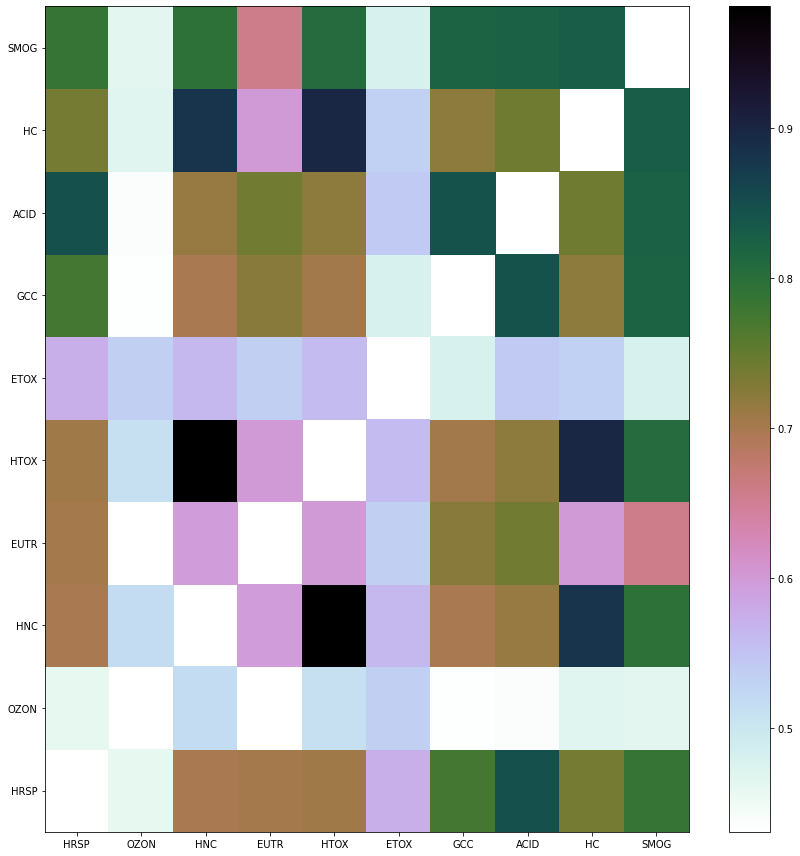

In [197]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(12, 12)

masked_correlation = np.ma.array(correlation_matrix, mask=correlation_matrix == 0).T
plt.pcolor(masked_correlation, cmap=plt.cm.cubehelix_r)
plt.colorbar()
plt.ylim(None, correlation_matrix.shape[1])
plt.xlim(None, correlation_matrix.shape[0])
plt.xticks(np.arange(0.5, 10), [obj[1] for obj in categories_in_order])
plt.yticks(np.arange(0.5, 10), [obj[1] for obj in categories_in_order])
plt.tight_layout()

In [203]:
for category in categories_in_order:
    print(category[1], bd.methods[category]['description'], '\n')

HRSP Human Health - Respiratory Effects
These indicators provide estimates of stress or potential impacts on specific environmental and human health aspects. The indicators in this category applied here are from TRACI 2.1 (Bare 2012). See the dataset 'USEEIO v1.1 - Elementary Flows and Life Cycle Impact Assessment (LCIA) Characterization Factors' for details, DOI: 10.23719/1368541 

OZON Ozone Depletion
These indicators provide estimates of stress or potential impacts on specific environmental and human health aspects. The indicators in this category applied here are from TRACI 2.1 (Bare 2012). See the dataset 'USEEIO v1.1 - Elementary Flows and Life Cycle Impact Assessment (LCIA) Characterization Factors' for details, DOI: 10.23719/1368541 

HNC Human Health Noncancer
These indicators provide estimates of stress or potential impacts on specific environmental and human health aspects. The indicators in this category applied here are from TRACI 2.1 (Bare 2012). See the dataset 'USEEIO v